In [ ]:
from utils.helper import preprocess_runs

path_name_dict = {
    'JOB-Light': 'JOB-light.json',
    'JOB': 'JOB.json',
    'JOB-Complex': 'JOB-Complex.json'
}
benchmark_stats_dict = preprocess_runs(json_path='workload_runs',path_name_dict=path_name_dict)

Loading run files from workload_runs
Benchmark: JOB-Light (140 plans)


Cleaning SQL: 100%|██████████| 140/140 [00:04<00:00, 29.82it/s]


Benchmark: JOB (37085 plans)


Cleaning SQL: 100%|██████████| 37085/37085 [00:06<00:00, 5667.41it/s]


Benchmark: JOB-Complex (18479 plans)


Cleaning SQL: 100%|██████████| 18479/18479 [00:00<00:00, 63164.99it/s]


# Card Est Accuracy Analysis

Benchmark      Num Queries    Avg Q-Error    Median Q-Error    90th Percentile Q-Error    95th Percentile Q-Error    Max Q-Error
-----------  -------------  -------------  ----------------  -------------------------  -------------------------  -------------
JOB-Light               70        160.691           7.40122                    163.573                     814.13        3488.55
JOB                    113       3086.33          277.698                     5868                       14638.5        52306
JOB-Complex             30       9754.82          757.5                      18235                       66423         107652


Benchmark      Num Queries    Avg Q-Error    Median Q-Error    90th Percentile Q-Error    95th Percentile Q-Error    Max Q-Error
-----------  -------------  -------------  ----------------  -------------------------  -------------------------  -------------
JOB-Light               70         1                      1                       1                  

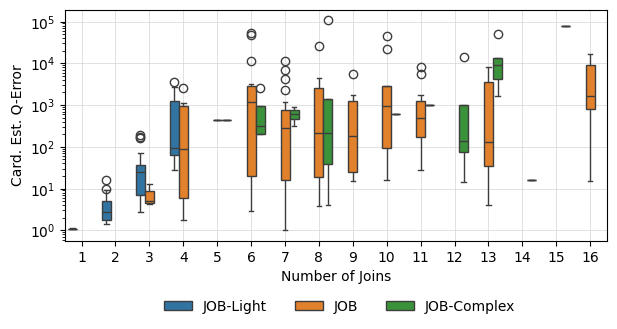

In [2]:
import pandas as pd
import numpy as np

opt_plan_card_qerrors = {}
pg_plan_card_qerrors = {}

df_list = []

# tabulate rows
pg_tabulate_rows = []
opt_tabulate_rows = []

card_error_vs_q_error = {}

for benchmark_name, info in benchmark_stats_dict.items():
    num_tables_list = []
    pgplan_act_card_list = []
    pgplan_est_card_list = []
    optplan_act_card_list = []
    optplan_est_card_list = []
    pg_cost = []
    pg_runtime = []
    pg_plan_qerror = []
    opt_plan_qerror = []

    for id, (sql, plan_info) in enumerate(info.items()):
        opt_rt = plan_info['opt_runtime']
        pg_rt = plan_info['pg_runtime']

        if opt_rt is None or pg_rt is None:
            print(f'Skip because of null: {opt_rt} / {pg_rt} / {sql}')
            continue

        num_tables_list.append(plan_info['num_tables'])

        # get postgres selected plan
        pgplan_act_card_list.append(plan_info['pg_plan_act_card_root'])
        pgplan_est_card_list.append(plan_info['pg_plan_est_card_root'])
        pg_plan_qerror.append(plan_info['pg_plan_card_error'])

        # get optimum selected plan
        optplan_act_card_list.append(plan_info['opt_plan_act_card_root'])
        optplan_est_card_list.append(plan_info['opt_plan_est_card_root'])
        opt_plan_qerror.append(plan_info['opt_plan_card_error'])

        pg_cost.append(plan_info['pg_plan_cost'])
        pg_runtime.append(pg_rt)

    # convert to df
    df = pd.DataFrame({
        'benchmark_name': [benchmark_name] * len(num_tables_list),
        'num_tables': num_tables_list,
        'pgplan_act_card': pgplan_act_card_list,
        'pgplan_est_card': pgplan_est_card_list,
        'optplan_act_card': optplan_act_card_list,
        'optplan_est_card': optplan_est_card_list,
        'pg_cost': pg_cost,
        'pg_runtime': pg_runtime,
        'pgplan_q_error': pg_plan_qerror,
        'optplan_q_error': opt_plan_qerror,
    })

    df['num_joins'] = df['num_tables'] - 1
    df_list.append(df)


    # compute avg q-error, median q-error, 95th percentile q-error
    def extract_stats(key: str):
        final_transformed = df[key][np.isfinite(df[key])]

        avg_q_error = np.mean(final_transformed)
        median_q_error = np.median(final_transformed)
        q_90th = np.percentile(final_transformed, 90)
        q_95th = np.percentile(final_transformed, 95)
        max_q_error = np.max(df[key])
        return avg_q_error, median_q_error, q_90th, q_95th, max_q_error


    opt_tabulate_rows.append([benchmark_name, len(info), *extract_stats('optplan_q_error')])
    pg_tabulate_rows.append([benchmark_name, len(info), *extract_stats('pgplan_q_error')])

# print tabulate rows
from tabulate import tabulate

print(tabulate(pg_tabulate_rows,
               headers=['Benchmark', 'Num Queries', 'Avg Q-Error', 'Median Q-Error', '90th Percentile Q-Error',
                        '95th Percentile Q-Error', 'Max Q-Error']))
print("\n")
print(tabulate(opt_tabulate_rows,
               headers=['Benchmark', 'Num Queries', 'Avg Q-Error', 'Median Q-Error', '90th Percentile Q-Error',
                        '95th Percentile Q-Error', 'Max Q-Error']))

import matplotlib.pyplot as plt
import seaborn as sns


def plot_boxplot(key='pgplan_q_error'):
    # concat dataframes
    df = pd.concat(df_list, ignore_index=True)

    # Plotting
    plt.figure(figsize=(7, 3))
    sns.boxplot(data=df, x='num_joins', y=key, hue='benchmark_name', showmeans=False, showfliers=True)

    # Customize plot
    # plt.title('Postgres Cardinality Estimates Boxplot')
    plt.xlabel('Number of Joins')
    plt.ylabel('Card. Est. Q-Error')
    plt.legend(frameon=False, ncol=3, loc='upper left', bbox_to_anchor=(0.16, -0.2))

    # add logscale on y-axis
    plt.grid(True, color='lightgrey', linewidth=0.7, alpha=0.7)
    plt.gca().set_axisbelow(True)

    plt.yscale('log')
    plt.savefig('tmp/card_est_boxplot.pdf', bbox_inches='tight', dpi=300, transparent=False)


plot_boxplot(key='pgplan_q_error')
# plot_boxplot(key='optplan_q_error') # we have supplied pg with actual cards - info not meaningful here

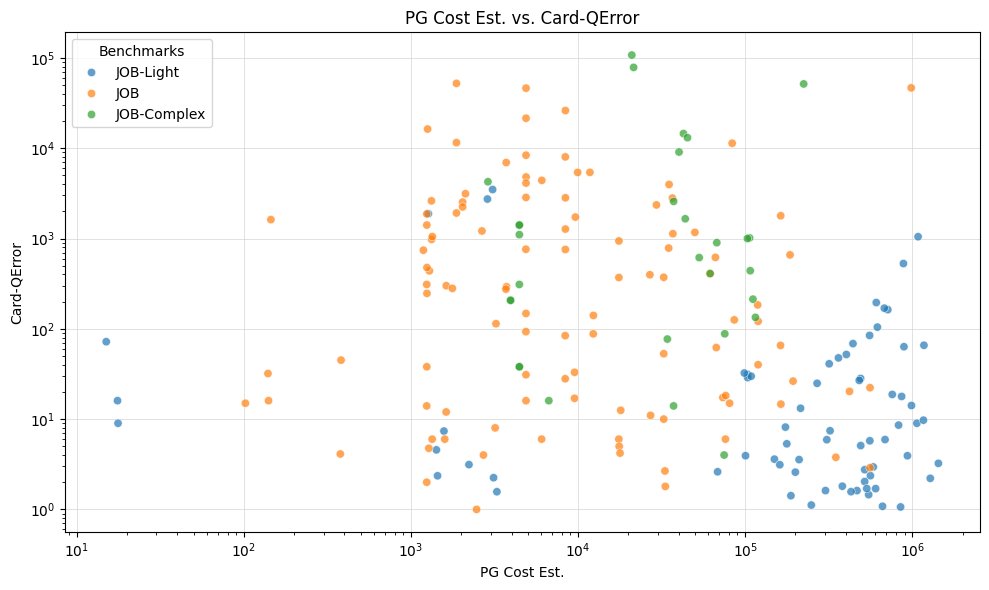

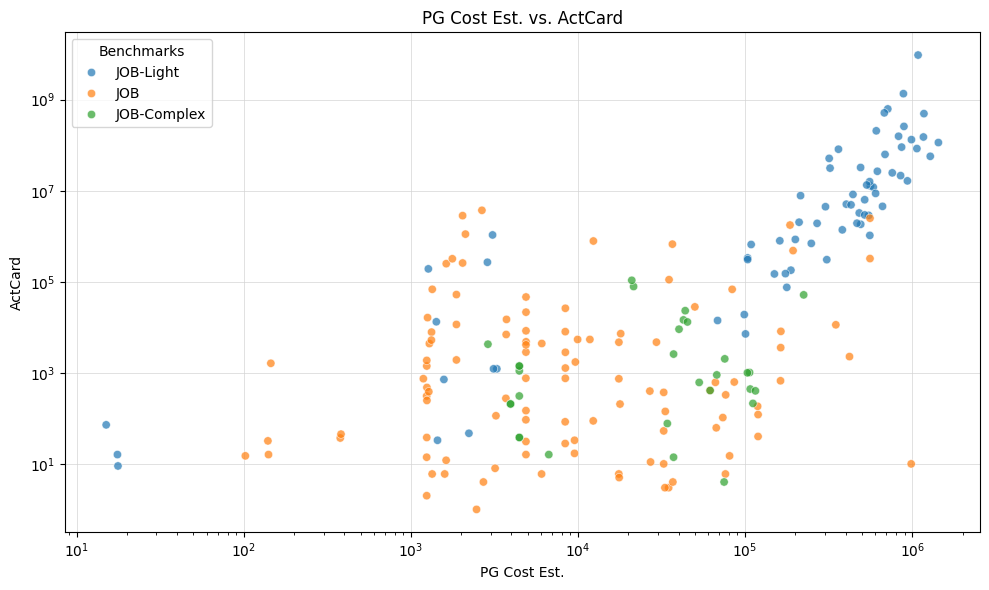

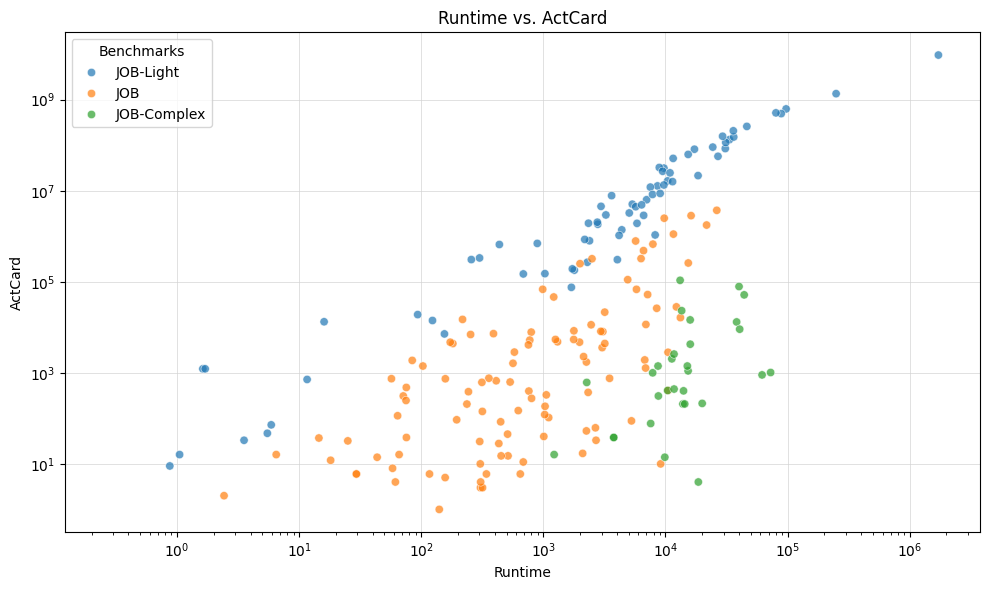

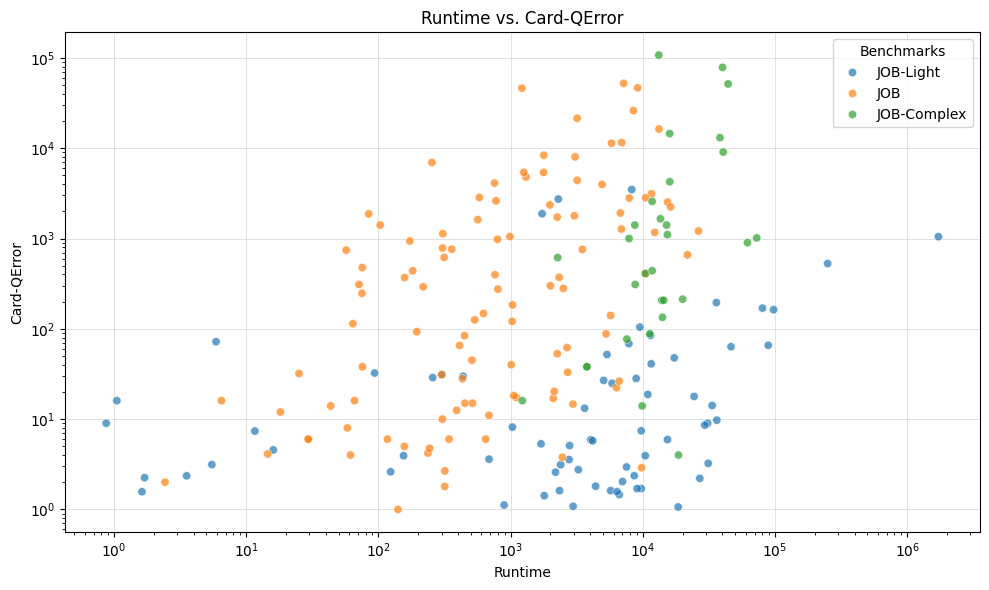

In [3]:
# create scatter plot pg_cost vs. pgplan_q_error
def plot_scatter_pg_cost_vs_q_error(xkey='pg_cost', xlabel='PG Cost Est.', ykey='pgplan_q_error', ylabel='Card-QError'):
    # concat dataframes
    df = pd.concat(df_list, ignore_index=True)

    # Plotting
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x=xkey, y=ykey, hue='benchmark_name', alpha=0.7)

    # Customize plot
    plt.title(f'{xlabel} vs. {ylabel}')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(title='Benchmarks')

    # add logscale on y-axis
    plt.xscale('log')
    plt.yscale('log')

    plt.grid(True, color='lightgrey', linewidth=0.7, alpha=0.7)
    plt.gca().set_axisbelow(True)

    plt.tight_layout()
    plt.show()


plot_scatter_pg_cost_vs_q_error()
plot_scatter_pg_cost_vs_q_error(ykey='pgplan_act_card', ylabel='ActCard')
plot_scatter_pg_cost_vs_q_error(ykey='pgplan_act_card', ylabel='ActCard', xkey='pg_runtime', xlabel='Runtime')
plot_scatter_pg_cost_vs_q_error(xkey='pg_runtime', xlabel='Runtime')

In [4]:
mismatches_list = []
mismatches_plans = []
key = 'JOB-Complex'
for sql, plan_info in benchmark_stats_dict[key].items():
    opt_plan = plan_info['opt_plan']
    act_card = plan_info['opt_plan_act_card_root']
    est_card = plan_info['opt_plan_est_card_root']

    if act_card != est_card:
        mismatches_list.append([act_card, est_card])
        mismatches_plans.append([opt_plan, sql, plan_info['opt_hint']])

print(f'Num Mismatches: {len(mismatches_list)} / {len(benchmark_stats_dict[key])}')

Num Mismatches: 3 / 30


In [5]:
pd.DataFrame(mismatches_list, columns=['Actual Card', 'Estimated Card'])

,Actual Card,Estimated Card
0,4,1
1,2027,23
2,440,1


In [6]:
import json

key = 0
print(mismatches_list[key])

print(f'SQL: {mismatches_plans[key][1]}')
print(f'Hint: {mismatches_plans[key][2]}')
print(json.dumps(mismatches_plans[key][0], indent=4))

[4, 1]
SQL: SELECT MIN(at.title) AS aka_title, MIN(t.title) AS internet_movie_title FROM aka_title AS at, company_name AS cn, company_type AS ct, info_type AS it1, keyword AS k, movie_companies AS mc, movie_info AS mi, movie_keyword AS mk, title AS t WHERE cn.country_code = '[us]' AND it1.info = 'release dates' AND mi.note LIKE '%internet%' AND t.production_year > 1990 AND t.id = at.movie_id AND t.id = mi.movie_id AND t.id = mk.movie_id AND t.id = mc.movie_id AND mk.movie_id = mi.movie_id AND mk.movie_id = mc.movie_id AND mk.movie_id = at.movie_id AND mi.movie_id = mc.movie_id AND mi.movie_id = at.movie_id AND mc.movie_id = at.movie_id AND k.id = mk.keyword_id AND it1.id = mi.info_type_id AND cn.id = mc.company_id AND ct.id = mc.company_type_id AND cn.name_pcode_nf = k.phonetic_code AND cn.name_pcode_sf = k.phonetic_code;
Hint: /*+Leading(mi at mc cn t mk k)*/
{
    "Plan": {
        "Node Type": "Aggregate",
        "Strategy": "Plain",
        "Partial Mode": "Simple",
        "Paral